In [ ]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [1]:
import numpy as np
import tensorflow as tf
import re
import pandas as pd
import spacy
import gc
from itertools import combinations
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix, vstack as sparse_vstack
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import Model, Input, layers
from tensorflow.keras.layers import Embedding, Dot, Reshape, Dense,Bidirectional, LSTM, GRU
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import skipgrams, pad_sequences
from keras.callbacks import TensorBoard

# **FASE 1**

In [2]:
# Step 1: Load data
train_df = pd.read_csv('train.csv', encoding='latin1')
test_df = pd.read_csv('test.csv', encoding='latin1')

def limpiar_texto(texto):
    texto = re.sub(r'[^\w\s]', '', str(texto)).lower()
    return texto

In [3]:
# # Step 2: Prepare data
# train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
# test_df['text_clean'] = test_df['text'].apply(limpiar_texto)
# corpus = pd.concat([train_df['text_clean'], test_df['text_clean']]).tolist()

# #cuando aumentemos a todo el corpus poner estas 2 líenas solo para dataset compelto y elimianr lo de small_corpus
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(corpus)

# # Identificar las 10 palabras más utilizadas con significado (susantivos) cargando el modelo de spaCy en inglés
# try:
#     nlp = spacy.load("en_core_web_sm")
# except OSError:
#     import os
#     os.system("python -m spacy download en_core_web_sm")
#     nlp = spacy.load("en_core_web_sm")

# # Crear el set de stopwords incluyendo 'nan'
# stop_words = set(nlp.Defaults.stop_words)
# stop_words.add('nan')

# # Función para filtrar solo nombres con significado
# def es_nombre_con_significado(palabra):
#     if len(palabra) < 2 or palabra in stop_words:
#         return False
#     doc = nlp(palabra)
#     # Solo acepta si la palabra es un sustantivo (NOUN o PROPN)
#     return any(token.pos_ in {"NOUN", "PROPN"} for token in doc)

# # Aplicar filtro al vocabulario real
# palabras_filtradas = {
#     word: count for word, count in tokenizer.word_counts.items()
#     if es_nombre_con_significado(word)
# }

# # Ordenar y seleccionar top 10
# top_10 = sorted(palabras_filtradas.items(), key=lambda x: x[1], reverse=True)[:10]

# # Mostrar resultados
# print("\nTop 10 nombres con significado:")
# print("━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━")
# for idx, (palabra, freq) in enumerate(top_10, 1):
#     print(f"{idx:2}. {palabra:<15} → {freq:>6} apariciones")


# # Convertir textos a secuencias de enteros
# train_sequences = tokenizer.texts_to_sequences(train_df['text_clean'])
# test_sequences = tokenizer.texts_to_sequences(test_df['text_clean'])
# all_sequences = train_sequences + test_sequences

# # Diccionarios de palabras a índices y viceversa
# word2idx = tokenizer.word_index
# idx2word = {i: w for w, i in word2idx.items()}
# vocab_size = len(word2idx) + 1



# --- Step 2: Prepare data (10% train + 10% test) ---

# 1) Carga y limpieza
train_df['text_clean'] = train_df['text'].apply(limpiar_texto)
test_df ['text_clean'] = test_df ['text'].apply(limpiar_texto)


train_corpus = train_df['text_clean'].tolist()
test_corpus  = test_df ['text_clean'].tolist()
corpus       = train_corpus + test_corpus

print(f"Frases usadas → train: {len(train_corpus)}, test: {len(test_corpus)}")

# 3) Tokenizer limitado a 3000 palabras + OOV
tokenizer = Tokenizer(num_words=3000, oov_token='<OOV>')
tokenizer.fit_on_texts(corpus)
vocab_size = 3000 + 1

# Diccionarios para después
word2idx = tokenizer.word_index
idx2word = {i:w for w,i in word2idx.items()}

# 4) Top-10 nombres con spaCy
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

stop_words = set(nlp.Defaults.stop_words) | {'nan'}


Frases usadas → train: 27481, test: 4815


In [4]:
train_df.head(1)

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²),text_clean
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346,652860.0,60,id have responded if i were going


In [ ]:
len(tokenizer.word_index)

# **FASE 2**

In [6]:
# Lista de palabras a analizar
palabras = [w for w in tokenizer.word_counts if len(w) >= 2 and w not in stop_words]

# Procesamos todas las palabras de una vez (más eficiente)
docs = list(nlp.pipe(palabras, batch_size=1000))

# Filtramos por NOUN o PROPN
filtradas = {
    w: tokenizer.word_counts[w]
    for w, doc in zip(palabras, docs)
    if any(token.pos_ in {"NOUN", "PROPN"} for token in doc)
}

# Top 10
top_10 = sorted(filtradas.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nombres con significado:")
for i, (w, f) in enumerate(top_10, 1):
    print(f"{i}. {w:<15} → {f} apariciones")


Top 10 nombres con significado:
1. day             → 2269 apariciones
2. love            → 1281 apariciones
3. today           → 1218 apariciones
4. lol             → 1062 apariciones
5. time            → 1056 apariciones
6. night           → 834 apariciones
7. home            → 800 apariciones
8. mothers         → 798 apariciones
9. thanks          → 745 apariciones
10. hope            → 660 apariciones


In [7]:
# 5) Secuencias
train_sequences = tokenizer.texts_to_sequences(train_corpus)
test_sequences  = tokenizer.texts_to_sequences(test_corpus)
all_sequences        = train_sequences + test_sequences

In [14]:
from tensorflow.keras.preprocessing.sequence import skipgrams

# Paso 3: Generación de pares con ventanas 2 y 4
pairs_dict = {
    'window_2': [],
    'window_4': []
}

for seq in all_sequences:
    # Ventana 2
    sg_pairs_2, labels_2 = skipgrams(seq, vocab_size, window_size=2, negative_samples=1)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_2'].extend(zip(sg_pairs_2, labels_2))  # Añadir las etiquetas (0 o 1)

    # Ventana 4
    sg_pairs_4, labels_4 = skipgrams(seq, vocab_size, window_size=4, negative_samples=1)
    # Generar pares con etiquetas y añadir a pairs_dict
    pairs_dict['window_4'].extend(zip(sg_pairs_4, labels_4))  # Añadir las etiquetas (0 o 1)


In [20]:
from tensorflow.keras.optimizers import Adam
# Hiperparámetros y estructuras
embedding_sizes  = [45,312,752]
window_sizes     = ['window_2','window_4']
loss_histories   = {}
final_embeddings = {}
models           = {}

for emb_size in embedding_sizes:
    for window in window_sizes:
        current_pairs = pairs_dict[window]
        if not current_pairs:
            continue

        # Separar pares y etiquetas
        pairs, labels = zip(*current_pairs)  # ✅

        # Separar targets y contexts de los pares
        targets, contexts = zip(*pairs)

        # Convertir a arrays
        targets  = np.array(targets, dtype='int32')
        contexts = np.array(contexts, dtype='int32')
        y_train  = np.array(labels, dtype='float32')  # ✅ usar las etiquetas reales (1 o 0)

        # ENTRADAS como índices, no one-hot
        target_input = Input(shape=(), dtype='int32', name='target_input')
        context_input= Input(shape=(), dtype='int32', name='context_input')

        # Capa de embeddings compartida
        embedding_layer = Embedding(
            input_dim=vocab_size,
            output_dim=emb_size,
            name=f"embedding_{emb_size}_{window}"
        )

        # Vectores de palabras
        target_vector  = embedding_layer(target_input)
        context_vector = embedding_layer(context_input)

        # Producto punto
        dot_product = Dot(axes=-1)([target_vector, context_vector])
        dot_product = Reshape((1,))(dot_product)

        # Clasificador binario
        output = Dense(1, activation='sigmoid')(dot_product)

        # Construir modelo
        model = Model(inputs=[target_input, context_input], outputs=output)
        model.compile(
            loss='binary_crossentropy',
            optimizer=Adam(0.02),
            metrics=['accuracy']
        )

        # Guardar y entrenar
        key = f'emb_{emb_size}_{window}'
        models[key] = model
        history = model.fit(
            [targets, contexts],
            y_train,
            epochs=1,
            batch_size=256,
            verbose=1
        )

        loss_histories[key]   = history.history['loss']
        final_embeddings[key] = embedding_layer.get_weights()[0]

10833/10833 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.7857 - loss: 0.4702
19790/19790 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.7016 - loss: 0.5773
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 28s 2ms/step - accuracy: 0.6798 - loss: 0.5958
19790/19790 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step - accuracy: 0.6959 - loss: 0.5883
10833/10833 ━━━━━━━━━━━━━━━━━━━━ 29s 2ms/step - accuracy: 0.7834 - loss: 0.4762
19790/19790 ━━━━━━━━━━━━━━━━━━━━ 51s 2ms/step - accuracy: 0.7786 - loss: 0.4852


In [21]:
# Recorre cada modelo en el diccionario y muestra su summary
for key, mdl in models.items():
    print(f"\n=== Summary de {key} ===")
    mdl.summary()



=== Summary de emb_45_window_2 ===


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_9 (Dot)         │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_9 (Reshape) │ (None, 1)         │          0 │ dot_9[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │          2 │ reshape_9[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_45_window_4 ===


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_45_windo… │ (None, 45)        │    135,045 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_10 (Dot)        │ (None, 1)         │          0 │ embedding_45_win… │
│                     │                   │            │ embedding_45_win… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_10          │ (None, 1)         │          0 │ dot_10[0][0]      │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 1)         │          2 │ reshape_10[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 405,143 (1.55 MB)

 Trainable params: 135,047 (527.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 270,096 (1.03 MB)


=== Summary de emb_312_window_2 ===


Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_11 (Dot)        │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_11          │ (None, 1)         │          0 │ dot_11[0][0]      │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 1)         │          2 │ reshape_11[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_312_window_4 ===


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_312_wind… │ (None, 312)       │    936,312 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_12 (Dot)        │ (None, 1)         │          0 │ embedding_312_wi… │
│                     │                   │            │ embedding_312_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_12          │ (None, 1)         │          0 │ dot_12[0][0]      │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 1)         │          2 │ reshape_12[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,808,944 (10.72 MB)

 Trainable params: 936,314 (3.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,872,630 (7.14 MB)


=== Summary de emb_752_window_2 ===


Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_13 (Dot)        │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_13          │ (None, 1)         │          0 │ dot_13[0][0]      │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 1)         │          2 │ reshape_13[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)


=== Summary de emb_752_window_4 ===


Model: "functional_14"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ target_input        │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_input       │ (None)            │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_752_wind… │ (None, 752)       │  2,256,752 │ target_input[0][… │
│ (Embedding)         │                   │            │ context_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_14 (Dot)        │ (None, 1)         │          0 │ embedding_752_wi… │
│                     │                   │            │ embedding_752_wi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_14          │ (None, 1)         │          0 │ dot_14[0][0]      │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 1)         │          2 │ reshape_14[0][0]  │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 6,770,264 (25.83 MB)

 Trainable params: 2,256,754 (8.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 4,513,510 (17.22 MB)

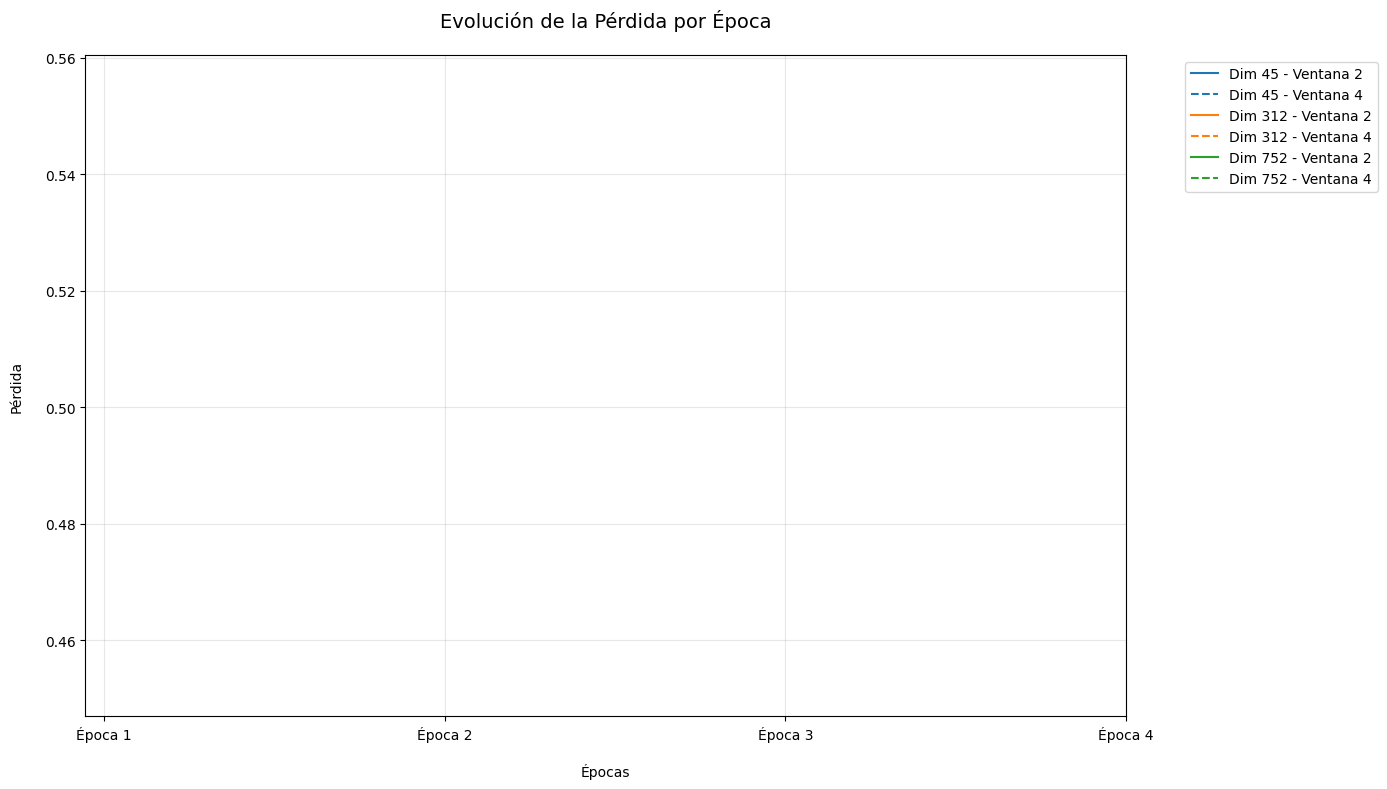

In [22]:
# Step 6: Visualización de la pérdida
plt.figure(figsize=(14, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for idx, emb_size in enumerate(embedding_sizes):
    for window in window_sizes:
        key = f'emb_{emb_size}_{window}'
        if key in loss_histories:
            plt.plot(
                loss_histories[key],
                linestyle='--' if 'window_4' in key else '-',
                color=colors[idx],
                label=f'Dim {emb_size} - Ventana {window.split("_")[1]}'
            )

plt.title('Evolución de la Pérdida por Época', pad=20, fontsize=14)
plt.xlabel('Épocas', labelpad=15)
plt.ylabel('Pérdida', labelpad=15)
plt.xticks(range(4), [f'Época {i+1}' for i in range(4)])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('loss_evolution.png', dpi=300, bbox_inches='tight')
plt.show()


In [23]:
# Example: vector for "love"
idx = word2idx["love"]

print(f"Embedding for 'love':\n{final_embeddings['emb_45_window_2'][idx]}")

Embedding for 'love':
[-1.0746423  -2.4364452  -2.8614442   0.9399752   2.6231253   3.1634507
 -0.64271283  0.4011929  -0.43507227  1.1347986   2.7564204   0.03622799
  1.4272007   3.0354226   1.8521204  -1.9877092  -1.5256106  -0.797642
  0.7232192   1.8502755  -1.3536264  -3.1641998  -0.7950444  -2.5381396
 -1.1720978  -1.392142   -2.5762856  -1.6323376   1.6328801  -0.3395405
  2.443332   -2.1718175   0.7687348  -0.84530723 -5.86416     1.9559119
 -1.044599   -0.7881887   2.2931635  -0.21935947 -1.6986942   2.237306
  1.7595768  -1.6902035  -0.39825028]


In [24]:


# 1) Lista de las 10 palabras puras (sin frecuencia)
top_10_words = [w for w,_ in top_10]

# 2) Extrae los índices solo de las que realmente estén en tu vocabulario
indices = []
words   = []
for w in top_10_words:
    if w in word2idx:
        indices.append(word2idx[w])
        words.append(w)
    else:
        print(f"Advertencia: '{w}' no está en el vocabulario")

# 3) Recorre cada modelo en final_embeddings
for model_key, emb_matrix in final_embeddings.items():
    # 4) Submatriz de solo las top palabras
    submat = emb_matrix[indices]            # (n_words, emb_dim)

    # 5) Calcula similitud de coseno
    sim_mat = cosine_similarity(submat)     # (n_words, n_words)

    # 6) Construye DataFrame y muestra
    print(f"\n— Similitud de coseno para {model_key} —")
    df_sim = pd.DataFrame(sim_mat, index=words, columns=words)
    display(df_sim)




— Similitud de coseno para emb_45_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.486901,0.743195,0.474885,0.630233,0.581249,0.434641,0.743055,0.304090,0.563622
love,0.486901,1.000000,0.530617,0.593954,0.402509,0.318268,0.408710,0.408379,0.521371,0.642016
today,0.743195,0.530617,1.000000,0.605658,0.613998,0.536416,0.543251,0.397000,0.410876,0.563375
lol,0.474885,0.593954,0.605658,1.000000,0.570278,0.589607,0.608496,0.296010,0.572648,0.541919
time,0.630233,0.402509,0.613998,0.570278,1.000000,0.621928,0.537900,0.338913,0.206393,0.490463
night,0.581249,0.318268,0.536416,0.589607,0.621928,1.000000,0.580188,0.344518,0.254538,0.381824
home,0.434641,0.408710,0.543251,0.608496,0.537900,0.580188,1.000000,0.276604,0.337507,0.428480
mothers,0.743055,0.408379,0.397000,0.296010,0.338913,0.344518,0.276604,1.000000,0.310352,0.445921
thanks,0.304090,0.521371,0.410876,0.572648,0.206393,0.254538,0.337507,0.310352,1.000000,0.478372
hope,0.563622,0.642016,0.563375,0.541919,0.490463,0.381824,0.428480,0.445921,0.478372,1.000000



— Similitud de coseno para emb_45_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.559900,0.685371,0.581533,0.701429,0.740689,0.481447,0.313480,0.422066,0.608506
love,0.559900,1.000000,0.631473,0.659728,0.511901,0.663108,0.550967,0.577195,0.612361,0.660729
today,0.685371,0.631473,1.000000,0.680293,0.602544,0.716067,0.661712,0.559807,0.553741,0.583052
lol,0.581533,0.659728,0.680293,1.000000,0.651069,0.676459,0.672432,0.638771,0.549082,0.532550
time,0.701429,0.511901,0.602544,0.651069,1.000000,0.687584,0.595579,0.570382,0.495749,0.541237
night,0.740689,0.663108,0.716067,0.676459,0.687584,1.000000,0.678399,0.621413,0.582831,0.591485
home,0.481447,0.550967,0.661712,0.672432,0.595579,0.678399,1.000000,0.558046,0.475837,0.623738
mothers,0.313480,0.577195,0.559807,0.638771,0.570382,0.621413,0.558046,1.000000,0.602168,0.453682
thanks,0.422066,0.612361,0.553741,0.549082,0.495749,0.582831,0.475837,0.602168,1.000000,0.347919
hope,0.608506,0.660729,0.583052,0.532550,0.541237,0.591485,0.623738,0.453682,0.347919,1.000000



— Similitud de coseno para emb_312_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.172017,0.052324,0.180086,0.206568,0.347149,0.260705,-0.073896,0.185516,0.140912
love,0.172017,1.000000,0.367590,0.282050,0.210395,0.176245,0.150644,0.185664,0.138553,0.352982
today,0.052324,0.367590,1.000000,0.223055,0.235071,0.095233,0.125203,0.166034,0.144100,0.214417
lol,0.180086,0.282050,0.223055,1.000000,0.255695,0.301083,0.328742,0.275311,0.053846,0.171953
time,0.206568,0.210395,0.235071,0.255695,1.000000,0.231504,0.167270,0.287537,0.265401,0.116511
night,0.347149,0.176245,0.095233,0.301083,0.231504,1.000000,0.177375,0.194750,0.249988,0.158737
home,0.260705,0.150644,0.125203,0.328742,0.167270,0.177375,1.000000,0.131396,0.156438,0.209787
mothers,-0.073896,0.185664,0.166034,0.275311,0.287537,0.194750,0.131396,1.000000,0.258260,0.129270
thanks,0.185516,0.138553,0.144100,0.053846,0.265401,0.249988,0.156438,0.258260,1.000000,0.201267
hope,0.140912,0.352982,0.214417,0.171953,0.116511,0.158737,0.209787,0.129270,0.201267,1.000000



— Similitud de coseno para emb_312_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000001,0.207108,0.241204,0.153714,0.367542,0.259625,0.221608,0.028875,0.160241,0.209501
love,0.207108,1.000000,0.337551,0.232741,0.260926,0.254375,0.256344,0.236492,0.194889,0.263071
today,0.241204,0.337551,1.000000,0.287336,0.314452,0.185796,0.283251,0.327090,0.237922,0.188343
lol,0.153714,0.232741,0.287336,1.000000,0.308332,0.255752,0.127527,0.289551,0.096899,0.195874
time,0.367542,0.260926,0.314452,0.308332,1.000000,0.339177,0.216752,0.393114,0.221828,0.309314
night,0.259625,0.254375,0.185796,0.255752,0.339177,1.000000,0.166864,0.273139,0.234628,0.256594
home,0.221608,0.256344,0.283251,0.127527,0.216752,0.166864,1.000000,0.227545,0.134786,0.208657
mothers,0.028875,0.236492,0.327090,0.289551,0.393114,0.273139,0.227545,1.000000,0.269318,0.210731
thanks,0.160241,0.194889,0.237922,0.096899,0.221828,0.234628,0.134786,0.269318,1.000000,0.175189
hope,0.209501,0.263071,0.188343,0.195874,0.309314,0.256594,0.208657,0.210731,0.175189,1.000000



— Similitud de coseno para emb_752_window_2 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.343407,0.389545,0.256674,0.343266,0.444859,0.253996,0.622158,0.220863,0.313808
love,0.343407,1.000000,0.243603,0.290496,0.246688,0.255775,0.197228,0.337127,0.294556,0.246467
today,0.389545,0.243603,1.000000,0.295943,0.271497,0.243125,0.275415,0.171245,0.209205,0.336509
lol,0.256674,0.290496,0.295943,1.000000,0.301679,0.373978,0.314449,0.205443,0.318057,0.322313
time,0.343266,0.246688,0.271497,0.301679,1.000000,0.325700,0.224068,0.181950,0.213850,0.225923
night,0.444859,0.255775,0.243125,0.373978,0.325700,1.000000,0.328536,0.341290,0.230792,0.273349
home,0.253996,0.197228,0.275415,0.314449,0.224068,0.328536,1.000000,0.178818,0.092033,0.264821
mothers,0.622158,0.337127,0.171245,0.205443,0.181950,0.341290,0.178818,1.000000,0.209781,0.201998
thanks,0.220863,0.294556,0.209205,0.318057,0.213850,0.230792,0.092033,0.209781,1.000000,0.248610
hope,0.313808,0.246467,0.336509,0.322313,0.225923,0.273349,0.264821,0.201998,0.248610,1.000000



— Similitud de coseno para emb_752_window_4 —


,day,love,today,lol,time,night,home,mothers,thanks,hope
day,1.000000,0.306861,0.468943,0.290826,0.345190,0.353383,0.285191,0.602933,0.255903,0.425835
love,0.306861,1.000000,0.211363,0.326669,0.270135,0.237983,0.174813,0.318850,0.295687,0.319314
today,0.468943,0.211363,1.000000,0.263664,0.251718,0.285187,0.252923,0.252831,0.187690,0.266094
lol,0.290826,0.326669,0.263664,1.000000,0.235021,0.318529,0.211719,0.216456,0.258122,0.222042
time,0.345190,0.270135,0.251718,0.235021,1.000000,0.248399,0.173305,0.259989,0.313026,0.223878
night,0.353383,0.237983,0.285187,0.318529,0.248399,1.000000,0.269485,0.232633,0.150647,0.291514
home,0.285191,0.174813,0.252923,0.211719,0.173305,0.269485,1.000000,0.174959,0.150246,0.143426
mothers,0.602933,0.318850,0.252831,0.216456,0.259989,0.232633,0.174959,1.000000,0.226769,0.290919
thanks,0.255903,0.295687,0.187690,0.258122,0.313026,0.150647,0.150246,0.226769,1.000000,0.287210
hope,0.425835,0.319314,0.266094,0.222042,0.223878,0.291514,0.143426,0.290919,0.287210,1.000000


In [25]:


# Define aquí tres grupos basados en tu top-10
grupos = {
    'Día/Mañana':     ['day', 'today', 'morning'],
    'Emoción Positiva':['love', 'hope', 'thanks'],
    'Risa/Conversación':['lol', 'thanks', 'mothers']  # ejemplo mixto
}

for model_key, emb_matrix in final_embeddings.items():
    print(f"\n=== Similitudes para {model_key} ===")
    # Extrae solo los vectores de tus 10 palabras
    submat = emb_matrix[indices]           # (10, emb_dim)
    sim_mat = cosine_similarity(submat)    # (10, 10)

    # Mapea palabra -> posición en 'words'
    pos = {w:i for i,w in enumerate(words)}

    for nombre, group in grupos.items():
        # Filtra solo los que realmente están en tu top
        valid = [w for w in group if w in pos]
        idxs  = [pos[w] for w in valid]
        if len(idxs) < 2:
            print(f"  * Grupo «{nombre}» tiene <2 palabras válidas, omito.")
            continue

        sims = []
        print(f"\n  Grupo «{nombre}»: {valid}")
        for i,j in combinations(idxs, 2):
            s = sim_mat[i, j]
            sims.append(s)
            print(f"    Sim({words[i]}, {words[j]}) = {s:.3f}")

        print(f"    → Similitud media = {np.mean(sims):.3f}")




=== Similitudes para emb_45_window_2 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = 0.743
    → Similitud media = 0.743

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.642
    Sim(love, thanks) = 0.521
    Sim(hope, thanks) = 0.478
    → Similitud media = 0.547

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = 0.573
    Sim(lol, mothers) = 0.296
    Sim(thanks, mothers) = 0.310
    → Similitud media = 0.393

=== Similitudes para emb_45_window_4 ===

  Grupo «Día/Mañana»: ['day', 'today']
    Sim(day, today) = 0.685
    → Similitud media = 0.685

  Grupo «Emoción Positiva»: ['love', 'hope', 'thanks']
    Sim(love, hope) = 0.661
    Sim(love, thanks) = 0.612
    Sim(hope, thanks) = 0.348
    → Similitud media = 0.540

  Grupo «Risa/Conversación»: ['lol', 'thanks', 'mothers']
    Sim(lol, thanks) = 0.549
    Sim(lol, mothers) = 0.639
    Sim(thanks, mothers) = 0.602
    → Similitud media = 0.597

=== Simil

# **FASE 3**

<Axes: >

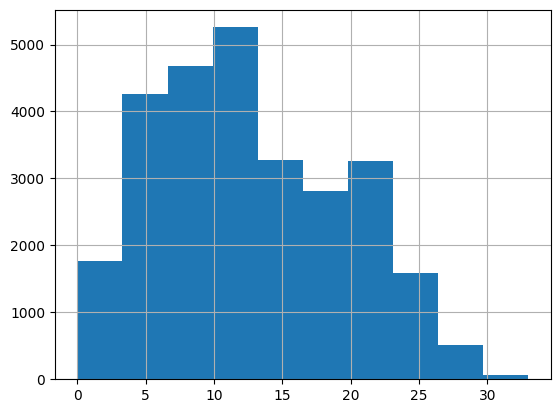

In [27]:
import matplotlib.pyplot as plt
train_df['text_clean'].str.split().map(len).hist()

In [60]:
# --- FASE 3: DOS RNN SECUENCIALES CON EMBEDDINGS PRE-ENTRENADOS ---

# Parámetros generales
maxlen        = 32
batch_rnn     = 64
epochs_rnn    = 5
learning_rate = 0.005

# 1) Usa SMALL_TRAIN_DF / SMALL_TEST_DF y quita filas sin etiqueta
train_df.dropna(subset=['sentiment'], inplace=True)
test_df.dropna(subset=['sentiment'], inplace=True)

texts_train = train_df['text_clean'].tolist()
texts_test  = test_df['text_clean'].tolist()

# 2) LabelEncoder para convertir strings → enteros
le       = LabelEncoder()
y_train  = le.fit_transform(train_df['sentiment'])
y_test   = le.transform(test_df['sentiment'])
y_train  = y_train.astype('int32')
y_test   = y_test.astype('int32')
num_classes = len(le.classes_)
print("Clases sentiment codificadas:", le.classes_)

# 3) Secuencias + padding
seq_train = tokenizer.texts_to_sequences(texts_train)
seq_test  = tokenizer.texts_to_sequences(texts_test)
X_train   = pad_sequences(seq_train, maxlen=maxlen, padding='post')
X_test    = pad_sequences(seq_test,  maxlen=maxlen, padding='post')

# 4) Crea datasets optimizados
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)) \
                         .shuffle(len(X_train)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)
test_ds  = tf.data.Dataset.from_tensor_slices((X_test, y_test)) \
                         .batch(batch_rnn) \
                         .prefetch(tf.data.AUTOTUNE)

# 5) Elige qué embeddings usar
key_A = 'emb_45_window_2'
key_B = 'emb_312_window_4'
emb_A = final_embeddings[key_A]
emb_B = final_embeddings[key_B]
vocab_sz = vocab_size



Clases sentiment codificadas: ['negative' 'neutral' 'positive']


In [63]:
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dropout

# --- Modelo A con regularización y dropout ---
model_A = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_A.shape[1],
              weights=[emb_A],
              mask_zero=False,
              trainable=False),
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.4),
    Bidirectional(GRU(64)),
    Dropout(0.4),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_A')

model_A.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_A.summary()
# --- Modelo B con regularización y dropout ---
model_B = keras.Sequential([
    Embedding(input_dim=vocab_sz,
              output_dim=emb_B.shape[1],
              weights=[emb_B],
              mask_zero=False,
              trainable=False),
    Bidirectional(LSTM(32)),
    Dropout(0.5),
    Dense(64, activation='relu',
          kernel_regularizer=regularizers.l2(1e-4)),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
], name='Model_B')

model_B.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=['accuracy']
)
model_B.summary()

Model: "Model_A"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_30 (Embedding)        │ ?                      │       135,045 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_45                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_46                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_75 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_76 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 135,045 (527.52 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 135,045 (527.52 KB)

Model: "Model_B"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_31 (Embedding)        │ ?                      │       936,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_47                │ ?                      │   0 (unbuilt) │
│ (Bidirectional)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_77 (Dense)                │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_78 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 936,312 (3.57 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 936,312 (3.57 MB)

In [35]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',     # monitor validation loss
    factor=0.5,             # reduce by half
    patience=1,             # after 1 epoch with no improvement
    min_lr=1e-5,            # don't go below this
    verbose=1
)

In [64]:
## nota: PARA EJECUTAR DE NUEVO, ANTES EJECUTAR LA DEFINICIÓN DE LOS MODELOS PARA QUE EMPIECEN DE CERO
# 8) Entrena ambos
print("\n>>> Entrenando Model A")
history_A = model_A.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    callbacks=[reduce_lr]
)

print("\n>>> Entrenando Model B")
history_B = model_B.fit(
    train_ds,
    validation_data=test_ds,
    epochs=6,
    callbacks=[reduce_lr]
)




>>> Entrenando Model A
Epoch 1/6
430/430 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - accuracy: 0.5546 - loss: 0.9358 - val_accuracy: 0.6842 - val_loss: 0.7361 - learning_rate: 0.0050
Epoch 2/6
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6819 - loss: 0.7572 - val_accuracy: 0.7077 - val_loss: 0.6922 - learning_rate: 0.0050
Epoch 3/6
430/430 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - accuracy: 0.7032 - loss: 0.7104 - val_accuracy: 0.7100 - val_loss: 0.6796 - learning_rate: 0.0050
Epoch 4/6
430/430 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.7200 - loss: 0.6791 - val_accuracy: 0.7196 - val_loss: 0.6754 - learning_rate: 0.0050
Epoch 5/6
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7382 - loss: 0.6432 - val_accuracy: 0.7193 - val_loss: 0.6589 - learning_rate: 0.0050
Epoch 6/6
430/430 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step - accuracy: 0.7392 - loss: 0.6352 - val_accuracy: 0.7312 - val_loss: 0.6480 - learning_rate: 0.0050

>>> Entrenando Model B
Epoch 1/6
430/430 ━━━━━━━━━━━━━━━━━━━━ 

## MODELO A

In [65]:
import numpy as np

# Get predicted class probabilities
y_probs = model_A.predict(X_test)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


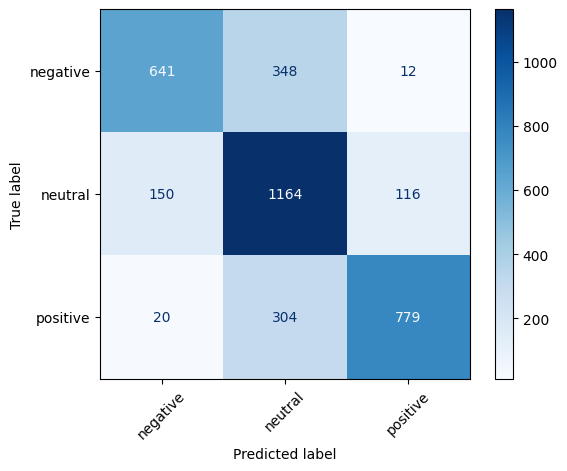

In [66]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


## MODELO B

In [67]:
import numpy as np

# Get predicted class probabilities
y_probs = model_B.predict(X_test)

# Get predicted class labels (highest probability)
y_pred = np.argmax(y_probs, axis=1)

111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


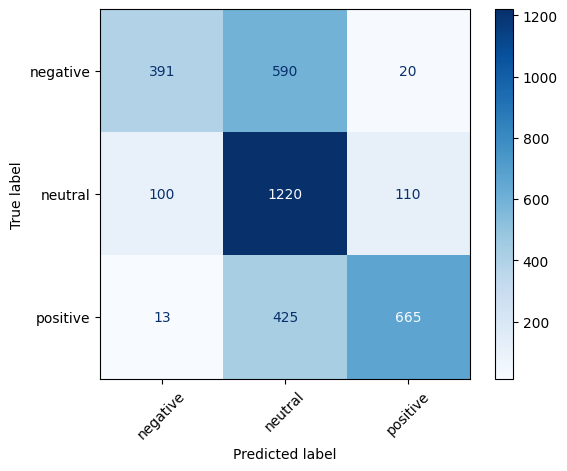

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display it nicely
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=45)


=== Evaluación en TEST ===

--- Model A ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.79      0.64      0.71      1001
     neutral       0.64      0.81      0.72      1430
    positive       0.86      0.71      0.78      1103

    accuracy                           0.73      3534
   macro avg       0.76      0.72      0.73      3534
weighted avg       0.75      0.73      0.73      3534


--- Model B ---
111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step

Classification Report:
              precision    recall  f1-score   support

    negative       0.78      0.39      0.52      1001
     neutral       0.55      0.85      0.67      1430
    positive       0.84      0.60      0.70      1103

    accuracy                           0.64      3534
   macro avg       0.72      0.62      0.63      3534
weighted avg       0.70      0.64      0.64      3534



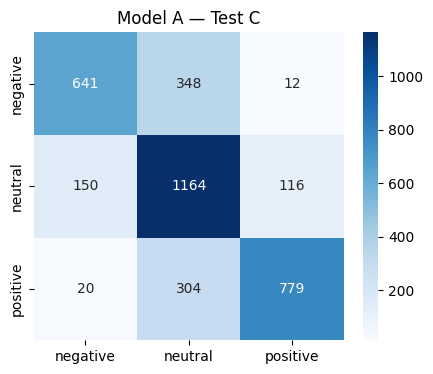

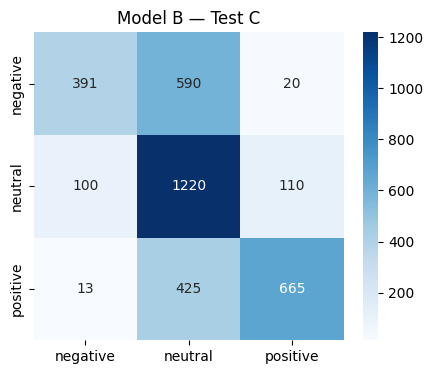

In [69]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

print("\n=== Evaluación en TEST ===")
for name, model in [('Model A', model_A), ('Model B', model_B)]:
    print(f"\n--- {name} ---")

    # Predicción en test
    y_test_probs = model.predict(X_test)
    y_test_pred = np.argmax(y_test_probs, axis=1)

    # Matriz de confusión
    cm_test = confusion_matrix(y_test, y_test_pred)

    # Métricas detalladas
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred, target_names=le.classes_))

    # Gráfico
    plt.figure(figsize=(5,4))
    sns.heatmap(cm_test, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f'{name} — Test C')


In [78]:
# List of sample indices to test
sample_indices = [0,1,2]

# Loop through each sample
for idx in sample_indices:
    # 1) Saca una frase de prueba
    sample_text = test_df['text_clean'].iloc[idx]
    print(f"\n-----\nSample text: {sample_text}")

    # 2) Tokeniza y paddea la frase
    sample_seq = tokenizer.texts_to_sequences([sample_text])
    sample_pad = pad_sequences(sample_seq, maxlen=maxlen, padding='post')

    # 3) MODELO A
    print("=================Utilizando el modelo A=================")
    model = model_A  # o model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")

    # MODELO B
    print("=================Utilizando el modelo B=================")
    model = model_B

    # 4) Predicción
    pred_probs = model.predict(sample_pad)
    pred_label = np.argmax(pred_probs, axis=1)[0]
    pred_class = le.inverse_transform([pred_label])[0]

    # Imprimir el resultado con las probabilidades de cada clase
    print(f"\nPredicted sentiment: {pred_class} with")

    # Especificar las probabilidades para cada clase (asumimos que hay 3 clases: negative, neutral, positive)
    labels = ['negative', 'neutral', 'positive']
    for i, prob in enumerate(pred_probs[0]):
        print(f"Probability of {labels[i]}: {prob:.8f}")



-----
Sample text: last session of the day  httptwitpiccom67ezh
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step

Predicted sentiment: neutral with
Probability of negative: 0.08914668
Probability of neutral: 0.83458674
Probability of positive: 0.07626665
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step

Predicted sentiment: neutral with
Probability of negative: 0.16741177
Probability of neutral: 0.67887354
Probability of positive: 0.15371470

-----
Sample text:  shanghai is also really exciting precisely  skyscrapers galore good tweeps in china  sh  bj
=================Utilizando el modelo A=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step

Predicted sentiment: positive with
Probability of negative: 0.00674913
Probability of neutral: 0.03770512
Probability of positive: 0.95554572
=================Utilizando el modelo B=================
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Predicted sen